# Path finding for an Multi-Orders Picking Robot in a Distribution Center with Q-Learning (and Back to Starting Point)

Consider an e-commerce company has a distribution center, and the company would like all of the picking operations in the center to be performed by warehouse robots.
* In the context of e-commerce warehousing, “picking” is the task of gathering individual items from various locations in the warehouse in order to fulfill customer orders.

After picking items from the shelves, the robots must bring the items to a specific location within the warehouse where the items can be packaged for shipping (starting point).

In order to ensure maximum efficiency and productivity, the robot will need to learn the shortest path between the item packaging area and all other locations within the warehouse where the robot is allowed to travel.
* We will use Q-learning to accomplish this task!

#### Import Required Libraries

In [29]:
#import libraries
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import colors
from IPython.display import Image
import random

## Define the Environment
The environment consists of **states**, **actions**, and **rewards**. States and actions are inputs for the Q-learning AI agent, while the possible actions are the AI agent's outputs.
#### States
The states in the environment are all of the possible locations within the warehouse. Some of these locations are for storing items (**gray squares**), while other locations are aisles that the robot can use to travel throughout the warehouse (**white squares**). The **green squares** indicates the item loactions.

The gray and green squares are **terminal states**!


The AI agent's goal is to learn the shortest path between the item packaging area and all of the other locations in the warehouse where the robot is allowed to travel.

As shown in the image above, there are 121 possible states (locations) within the warehouse. These states are arranged in a grid containing 11 rows and 11 columns. Each location can hence be identified by its row and column index.

In [30]:
#define the shape of the environment (i.e., its states)
environment_rows = 11
environment_columns = 11

#### Actions
The actions that are available to the AI agent are to move the robot in one of four directions:
* Up
* Right
* Down
* Left

Obviously, the AI agent must learn to avoid driving into the item storage locations (e.g., shelves)!


In [31]:
#define actions
#numeric action codes: 0 = up, 1 = right, 2 = down, 3 = left
actions = ['up', 'right', 'down', 'left']

#### Rewards
The last component of the environment that we need to define are the **rewards**.

To help the AI agent learn, each state (location) in the warehouse is assigned a reward value.

The agent may begin at any white square, but its goal is always the same: ***to maximize its total rewards***!

Negative rewards (i.e., **punishments**) are used for all states except the goal.
* This encourages the AI to identify the *shortest path* to the goal by *minimizing its punishments*!

To maximize its cumulative rewards (by minimizing its cumulative punishments), the AI agent will need find the shortest paths between the item locations (green squares) and all of the other locations in the warehouse where the robot is allowed to travel (white squares). The agent will also need to learn to avoid crashing into any of the item storage locations (gray squares)!

In [32]:
ORDER_REWARD = 100
TERMINAL_PENALTY = -100
STEP_PENALTY = -1
START = (1,5)

In [33]:
#Create a 2D numpy array to hold the rewards for each state.
#The array contains 11 rows and 11 columns (to match the shape of the environment), and each value is initialized to -100.
rewards = np.full((environment_rows, environment_columns), TERMINAL_PENALTY)

#define aisle locations (i.e., white squares) for rows 1 through 9
aisles = {} #store locations in a dictionary
aisles[0] = []
aisles[1] = [i for i in range(1,10)]
aisles[2] = [1, 5, 9]
aisles[3] = [1, 5, 9]
aisles[4] = [i for i in range(1,10)]
aisles[5] = [1, 5, 9]
aisles[6] = [i for i in range(1,10)]
aisles[7] = [1, 5, 9]
aisles[8] = [1, 5, 9]
aisles[9] = [i for i in range(1,10)]
aisles[10] = []

#set the rewards for all aisle locations (i.e., white squares)
for row_index in range(0, 11):
  for column_index in aisles[row_index]:
    rewards[row_index, column_index] = STEP_PENALTY

In [34]:
reward_locs = [(8,2),(2,7),(5,4),(8,7)]
reward_locs.append(START)
NUM_ORDERS = len(reward_locs)
NUM_ORDERS

5

# HOW TO GET BACK HOME
after finding the final order, we make the reward for the home 100, and also make sure to make NUM_ODERS += 1 so that the agent can go back home

In [35]:
#Create a 3D numpy array to hold the current Q-values for each state and action pair: Q(s, a)
#The array contains 11 rows and 11 columns (to match the shape of the environment), as well as a third "action" dimension.
#The "action" dimension consists of 4 layers that will allow us to keep track of the Q-values for each possible action in
#each state (see next cell for a description of possible actions).
#The value of each (state, action) pair is initialized to 0.
q_values = np.zeros((NUM_ORDERS, environment_rows, environment_columns, 4))
q_values.shape

(5, 11, 11, 4)

### Now we have q_values for each order:
Meaning that when we are looking for the first order, we are using `q_values[0] --> shape: (11, 11, 4)`. When the first order is done, we are using `q_values[1] --> shape: (11, 11, 4)`. And so on.

In [36]:
q_values[0].shape

(11, 11, 4)

In [37]:
# rewards[reward_locs[0][0], reward_locs[0][1]] = ORDER_REWARD #set the reward for the packaging area (i.e., the goal) to 100
# # rewards[3, 9] = ORDER_REWARD #set the reward for the packaging area (i.e., the goal) to 100
# rewards[reward_locs[1][0], reward_locs[1][1]] = ORDER_REWARD #set the reward for the packaging area (i.e., the goal) to 100
# rewards[reward_locs[2][0], reward_locs[2][1]] = ORDER_REWARD #set the reward for the packaging area (i.e., the goal) to 100

for loc in reward_locs[:-1]:
    print(loc)
    rewards[loc[0], loc[1]] = ORDER_REWARD #set the reward for the packaging area (i.e., the goal) to 100

(8, 2)
(2, 7)
(5, 4)
(8, 7)


In [38]:
REWARD_MAP = rewards.copy() # Reward map should contain the rewards for each state (normal rward gets updated each time step)
# for loc in reward_locs:
#     REWARD_MAP[loc[0], loc[1]] = ORDER_REWARD #set the reward for the packaging area (i.e., the goal) to 100

In [39]:
# #print rewards matrix
# for row in rewards:
#   print(row)
  

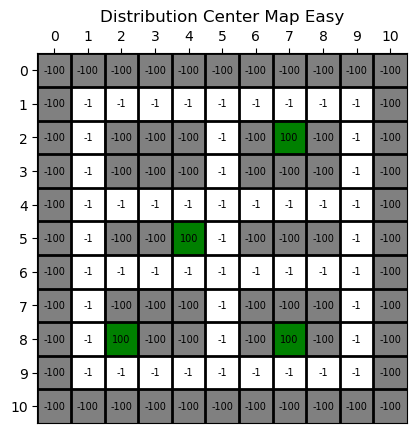

In [40]:
plt.figure()
colormap = colors.ListedColormap(["gray","white","green"])
im = plt.imshow(REWARD_MAP, cmap= colormap)

ax = plt.gca()

# Major ticks
ax.set_xticks(np.arange(0, 11, 1))
ax.set_yticks(np.arange(0, 11, 1))

# Labels for major ticks
ax.set_xticklabels(np.arange(0, 11, 1))
ax.set_yticklabels(np.arange(0, 11, 1))

# Minor ticks
ax.set_xticks(np.arange(-.5, 10, 1), minor=True)
ax.set_yticks(np.arange(-.5, 10, 1), minor=True)

# Let the horizontal axes labeling appear on top.
ax.tick_params(top=True, bottom=False,
                   labeltop=True, labelbottom=False)

for i in range(0,11):
    for j in range(0,11):
        text = ax.text(j, i, REWARD_MAP[i, j],
                       ha="center", va="center", color="black", fontsize=7)

# Gridlines based on minor ticks
ax.grid(which='minor', color='black', linestyle='-', linewidth=2)

# Remove minor ticks
ax.tick_params(which='minor', bottom=False, left=False)


ax.set_title("Distribution Center Map Easy")
plt.show()
# plt.savefig('Distribution-Center-Map-easy.jpg')

## Train the Model
Our next task is for our AI agent to learn about its environment by implementing a Q-learning model. The learning process will follow these steps:
1. Choose a random, non-terminal state (white square) for the agent to begin this new episode.
2. Choose an action (move *up*, *right*, *down*, or *left*) for the current state. Actions will be chosen using an *epsilon greedy algorithm*. This algorithm will usually choose the most promising action for the AI agent, but it will occasionally choose a less promising option in order to encourage the agent to explore the environment.
3. Perform the chosen action, and transition to the next state (i.e., move to the next location).
4. Receive the reward for moving to the new state, and calculate the temporal difference.
5. Update the Q-value for the previous state and action pair.
6. If the new (current) state is a terminal state, go to #1. Else, go to #2.

This entire process will be repeated across 1000 episodes. This will provide the AI agent sufficient opportunity to learn the shortest paths between the item packaging area and all other locations in the warehouse where the robot is allowed to travel, while simultaneously avoiding crashing into any of the item storage locations!

#### Define Helper Functions

In [41]:
#define a function that determines if the specified location is a terminal state
def is_terminal_state(current_row_index, current_column_index):
  #if the reward for this location is -1, then it is not a terminal state (i.e., it is a 'white square')
  if rewards[current_row_index, current_column_index] == TERMINAL_PENALTY:
    return True
  else:
    return False
  
def is_order_state(current_row_index, current_column_index):
  #if the reward for this location is -1, then it is not a terminal state (i.e., it is a 'white square')
  if rewards[current_row_index, current_column_index] ==  ORDER_REWARD:
    return True
  else:
    return False

# #define a function that will choose a random, non-terminal starting location
# def get_starting_location():
#   #get a random row and column index
#   current_row_index = np.random.randint(environment_rows)
#   current_column_index = np.random.randint(environment_columns)
#   #continue choosing random row and column indexes until a non-terminal state is identified
#   #(i.e., until the chosen state is a 'white square').
#   while is_terminal_state(current_row_index, current_column_index) or is_order_state(current_row_index, current_column_index):
#     current_row_index = np.random.randint(environment_rows)
#     current_column_index = np.random.randint(environment_columns)
#   return current_row_index, current_column_index

# if we wanted to start at a specific location, we could use this function:
def get_starting_location():
  return START[0], START[1]

#define an epsilon greedy algorithm that will choose which action to take next (i.e., where to move next)
def get_next_action(current_row_index, current_column_index, epsilon, order_number):
  #if a randomly chosen value between 0 and 1 is less than epsilon,
  #then choose the most promising value from the Q-table for this state.
  # order number is between 0 and NUM_ORDERS-1
  if np.random.random() < epsilon:
    return np.argmax(q_values[order_number, current_row_index, current_column_index])
  else: #choose a random action
    return np.random.randint(4)

#define a function that will get the next location based on the chosen action
def get_next_location(current_row_index, current_column_index, action_index):
  new_row_index = current_row_index
  new_column_index = current_column_index
  if actions[action_index] == 'up' and current_row_index > 0:
    new_row_index -= 1
  elif actions[action_index] == 'right' and current_column_index < environment_columns - 1:
    new_column_index += 1
  elif actions[action_index] == 'down' and current_row_index < environment_rows - 1:
    new_row_index += 1
  elif actions[action_index] == 'left' and current_column_index > 0:
    new_column_index -= 1
  else:
    raise Exception(f"Invalid action {action_index}")
  return new_row_index, new_column_index

#Define a function that will get the shortest path between any location within the warehouse that
#the robot is allowed to travel and the item packaging location.
def get_shortest_path(start_row_index, start_column_index, num_orders = NUM_ORDERS, max_length = 10000):
    local_rewards = REWARD_MAP.copy()
    left_orders = num_orders
    #return immediately if this is an invalid starting location
    if is_terminal_state(start_row_index, start_column_index) or is_order_state(start_row_index, start_column_index):
        print("You can't start at a terminal state or an order state!")
        return []
    else: #if this is a 'legal' starting location
        current_row_index, current_column_index = start_row_index, start_column_index
        shortest_path = []
        shortest_path.append([current_row_index, current_column_index])
        #continue moving along the path until we reach the goal (i.e., the item packaging location)
        while not is_terminal_state(current_row_index, current_column_index) and left_orders > 0:

            #get the best action to take | the 1. states that this is an exploitation-only policy
            action_index = get_next_action(current_row_index, current_column_index, 1., (num_orders - left_orders))
            #move to the next location on the path, and add the new location to the list
            current_row_index, current_column_index = get_next_location(current_row_index, current_column_index, action_index)
            shortest_path.append([current_row_index, current_column_index])
            
            if local_rewards[current_row_index, current_column_index] == ORDER_REWARD:
              left_orders -= 1
              print("Order found!  Remaining orders: ", left_orders)
              local_rewards[current_row_index, current_column_index] = STEP_PENALTY
            
            if left_orders == 1:
              local_rewards[START[0], START[1]] = ORDER_REWARD
              
              
            if len(shortest_path) > max_length:
              print("This path is taking too long to compute.  Something is wrong!")
              break
        plt.imshow(rewards_copy)
        plt.colorbar()
          
        return shortest_path

#### Train the AI Agent using Q-Learning

In [43]:
# Number of training episodes
num_episodes = 10000


#define training parameters
epsilon = 0.9 #the percentage of time when we should take the best action (instead of a random action)
discount_factor = 0.9 #discount factor for future rewards
learning_rate = 0.9 #the rate at which the AI agent should learn
# Counting the number of orders left.
gamma = 1-(1 / (num_episodes/2))
order_left = NUM_ORDERS

In [44]:
gamma

0.9998

In [45]:
from tqdm import tqdm


# Create a progress bar with the total number of episodes
progress_bar = tqdm(range(num_episodes), desc="Training Progress", unit="episode")

# Run through the training episodes
zero_order = 0
one_order = 0
episode_rewards_list = []
for episode in progress_bar:
    rewards_copy = rewards.copy()
    order_left = NUM_ORDERS 
    episode_rewards_sum = 0
    # get the starting location for this episode
    row_index, column_index = get_starting_location()

    # continue taking actions (i.e., moving) until we reach a terminal state
    # (i.e., until we reach the item packaging area or crash into an item storage location)
    while not is_terminal_state(row_index, column_index) and order_left > 0:
        # choose which action to take (i.e., where to move next)
        action_index = get_next_action(row_index, column_index, epsilon, (NUM_ORDERS-order_left))

        # perform the chosen action, and transition to the next state (i.e., move to the next location)
        old_row_index, old_column_index = row_index, column_index  # store the old row and column indexes
        row_index, column_index = get_next_location(row_index, column_index, action_index)

        # receive the reward for moving to the new state, and calculate the temporal difference

        reward = rewards_copy[row_index, column_index]
        episode_rewards_sum += reward
        
            
        old_q_value = q_values[(NUM_ORDERS - order_left), old_row_index, old_column_index, action_index]
        temporal_difference = reward + (discount_factor * np.max(q_values[(NUM_ORDERS - order_left), row_index, column_index])) - old_q_value

        # update the Q-value for the previous state and action pair
        new_q_value = old_q_value + (learning_rate * temporal_difference)
        q_values[(NUM_ORDERS - order_left), old_row_index, old_column_index, action_index] = new_q_value

        if int(reward) == int(ORDER_REWARD):
            order_left -= 1
            if order_left == 0:
                # print("Order left: ", order_left)
                zero_order += 1
            elif order_left == 1:
                one_order += 1
               
            rewards_copy[row_index, column_index] = STEP_PENALTY
            
            if order_left == 1:
                 rewards_copy[reward_locs[-1][0], reward_locs[-1][1]] = ORDER_REWARD


    episode_rewards_list.append(episode_rewards_sum) 


    # Update the progress bar description after each episode
    learning_rate = max(learning_rate * gamma, 0.01)
    epsilon = min(epsilon * (2-gamma), 0.9)
    
    
    progress_bar.set_postfix({"Ord left": order_left, "lr": learning_rate, "Eps": epsilon, "0 Order":zero_order, "1 Order":one_order})

# Close the progress bar after training is complete
progress_bar.close()


Training Progress: 100%|██████████| 10000/10000 [00:08<00:00, 1246.20episode/s, Ord left=2, lr=0.122, Eps=0.9, 0 Order=2193, 1 Order=3573]


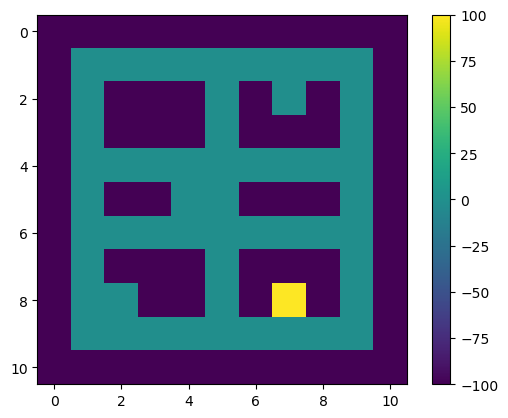

In [46]:
plt.imshow(rewards_copy)
plt.colorbar()

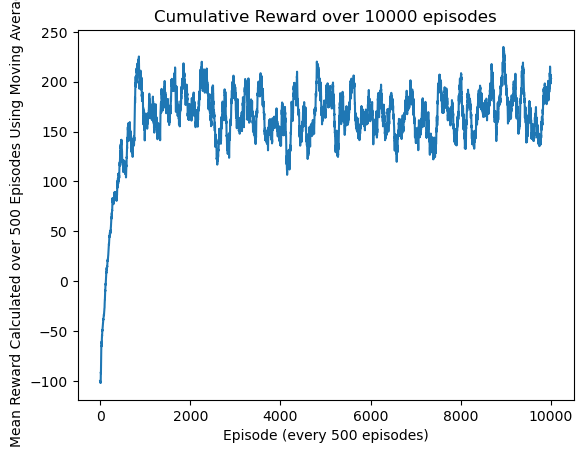

In [47]:
import pandas as pd
MEAN_OVER_N_EPISODES = 500
# smooth the curve using moving average
mean_reward_list = pd.Series(episode_rewards_list).rolling(100, min_periods=1).mean()
# plot the mean reward over the last N episodes
x_axis = np.arange(0, len(mean_reward_list), 1)
plt.plot(x_axis,mean_reward_list)
plt.xlabel(f"Episode (every {MEAN_OVER_N_EPISODES} episodes)")
plt.ylabel(f"Mean Reward Calculated over {MEAN_OVER_N_EPISODES} Episodes Using Moving Average")
plt.title(f"Cumulative Reward over {len(episode_rewards_list)} episodes")
plt.show()

In [48]:
ORDER_REWARD

100

## Get Shortest Paths
Now that the AI agent has been fully trained, we can see what it has learned by displaying the shortest path between any location in the warehouse where the robot is allowed to travel and the item packaging area.

Run the code cell below to try a few different starting locations!

In [49]:
# # get the image
# Image(url="images/Distribution-Center-Map-easy.jpg", width=500, height=500)

Order found!  Remaining orders:  4
Order found!  Remaining orders:  3
Order found!  Remaining orders:  2
Order found!  Remaining orders:  1
Order found!  Remaining orders:  0
[[1, 5], [1, 6], [1, 7], [2, 7], [1, 7], [1, 6], [1, 5], [2, 5], [3, 5], [4, 5], [4, 4], [5, 4], [6, 4], [6, 3], [6, 2], [6, 1], [7, 1], [8, 1], [8, 2], [9, 2], [9, 3], [9, 4], [9, 5], [9, 6], [9, 7], [8, 7], [9, 7], [9, 6], [9, 5], [8, 5], [7, 5], [6, 5], [5, 5], [4, 5], [3, 5], [2, 5], [1, 5]]


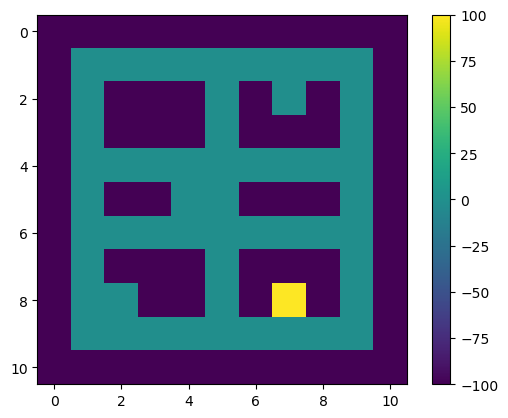

In [50]:
#display a few shortest paths
print(get_shortest_path(START[0], START[1])) #starting at row 3, column 9
# print(get_shortest_path(5, 0)) #starting at row 5, column 0
# print(get_shortest_path(9, 5)) #starting at row 9, column 5

In [56]:
# get the image
Image(url="images/QL-Multi-Orders-Back.png", width=700, height=500)

#### Finally...
It's great that our robot can automatically take the shortest path from any 'legal' location in the warehouse to the item packaging area. **But what about the opposite scenario?**

Put differently, our robot can currently deliver an item from anywhere in the warehouse ***to*** the packaging area, but after it delivers the item, it will need to travel ***from*** the packaging area to another location in the warehouse to pick up the next item!

Don't worry -- this problem is easily solved simply by ***reversing the order of the shortest path***.

Run the code cell below to see an example:

Order found!  Remaining orders:  4
Order found!  Remaining orders:  3
Order found!  Remaining orders:  2
Order found!  Remaining orders:  1
Order found!  Remaining orders:  0
[[1, 5], [2, 5], [3, 5], [4, 5], [5, 5], [6, 5], [7, 5], [8, 5], [9, 5], [9, 6], [9, 7], [8, 7], [9, 7], [9, 6], [9, 5], [9, 4], [9, 3], [9, 2], [8, 2], [8, 1], [7, 1], [6, 1], [6, 2], [6, 3], [6, 4], [5, 4], [4, 4], [4, 5], [3, 5], [2, 5], [1, 5], [1, 6], [1, 7], [2, 7], [1, 7], [1, 6], [1, 5]]


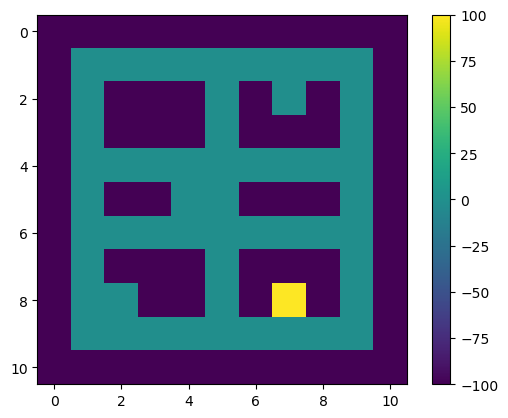

In [51]:
#display an example of reversed shortest path
path = get_shortest_path(START[0], START[1]) #go to row 5, column 2
path.reverse()
print(path)

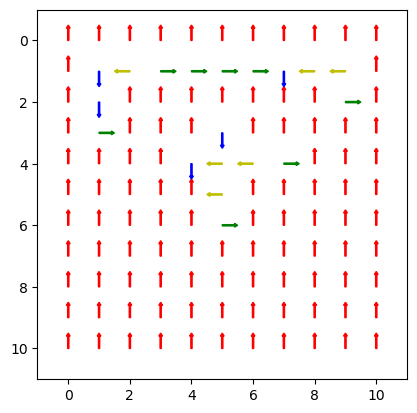

In [52]:
import numpy as np
import matplotlib.pyplot as plt

def plot_argmax_arrows(data):
    # Find the argmax along the last axis (axis=-1) to get the index of the maximum value in each element
    argmax_indices = np.argmax(data, axis=-1)
    
    # Create a plot with arrows based on the argmax values
    fig, ax = plt.subplots()
    
    for i, arrow_direction in enumerate(['up', 'right', 'down', 'left']):
        # Extract the indices where the argmax is equal to 'i'
        indices = np.argwhere(argmax_indices == i)
        
        if len(indices) > 0:
            # For each index, draw an arrow at that position with the corresponding direction
            for index in indices:
                if arrow_direction == 'up':
                    arrow = plt.Arrow(index[1], index[0], 0, -0.5, color='r', width=0.2)
                elif arrow_direction == 'right':
                    arrow = plt.Arrow(index[1], index[0], 0.5, 0, color='g', width=0.2)
                elif arrow_direction == 'down':
                    arrow = plt.Arrow(index[1], index[0], 0, 0.5, color='b', width=0.2)
                elif arrow_direction == 'left':
                    arrow = plt.Arrow(index[1], index[0], -0.5, 0, color='y', width=0.2)
                
                # Add the arrow to the plot
                ax.add_patch(arrow)
    
    # Set the aspect ratio to be equal to avoid distortion of the arrows
    ax.set_aspect('equal')
    
    # Show the plot
    plt.xlim(-1, data.shape[1])
    plt.ylim(data.shape[0], -1)
    plt.show()

# Example usage:
# Assuming 'data' is your array with 4 channels, adjust this with your data accordingly
data = q_values[0] # Replace this with your actual data
plot_argmax_arrows(data)


Order found!  Remaining orders:  4
Order found!  Remaining orders:  3
Order found!  Remaining orders:  2
Order found!  Remaining orders:  1
Order found!  Remaining orders:  0


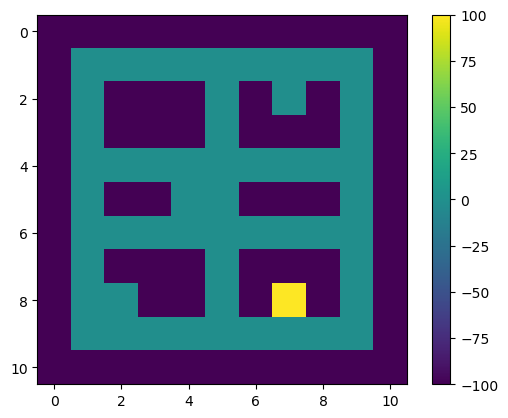

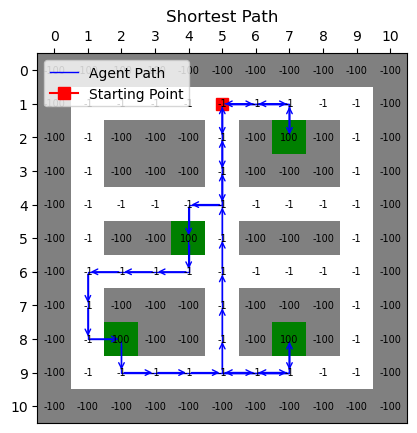

In [54]:
# Define a function to plot the agent's path
def plot_agent_path(agent_path, reward_locs, start_loc):
    plt.figure()
    colormap = colors.ListedColormap(["gray","white","green"])
    im = plt.imshow(REWARD_MAP, cmap=colormap)
    
    ax = plt.gca()

    # Plot agent's path as a continuous line with arrows indicating direction
    path_array = np.array(agent_path)
    ax.plot(path_array[:, 1], path_array[:, 0], color='blue', linewidth=1, label='Agent Path')
    
    # Plot arrows indicating direction
    for i in range(len(path_array) - 1):
        curr_row, curr_col = path_array[i]
        next_row, next_col = path_array[i + 1]
        arrow_props = dict(arrowstyle='->', linewidth=1, color='blue')
        ax.annotate('', xy=(next_col, next_row), xytext=(curr_col, curr_row), arrowprops=arrow_props)

    # Mark reward locations
    for reward_loc in reward_locs:
        row, col = reward_loc
        ax.plot(col, row, marker='o', markersize=8, color='green')
    
    # Mark the starting point
    start_row, start_col = start_loc
    ax.plot(start_col, start_row, marker='s', markersize=8, color='red', label='Starting Point')

    ax.set_xticks(np.arange(0, 11, 1))
    ax.set_yticks(np.arange(0, 11, 1))
    ax.set_xticklabels(np.arange(0, 11, 1))
    ax.set_yticklabels(np.arange(0, 11, 1))
    ax.tick_params(top=True, bottom=False, labeltop=True, labelbottom=False)
    
    for i in range(0, 11):
        for j in range(0, 11):
            text = ax.text(j, i, REWARD_MAP[i, j], ha="center", va="center", color="black", fontsize=7)

    ax.grid(which='minor', color='black', linestyle='-', linewidth=2)
    ax.tick_params(which='minor', bottom=False, left=False)

    ax.set_title("Shortest Path")
    plt.legend()
    plt.show()


# Plot the agent's path
start_row, start_col = get_starting_location()
agent_path = get_shortest_path(start_row, start_col)
plot_agent_path(agent_path, reward_locs, (start_row, start_col))

Order found!  Remaining orders:  4
Order found!  Remaining orders:  3
Order found!  Remaining orders:  2
Order found!  Remaining orders:  1
Order found!  Remaining orders:  0


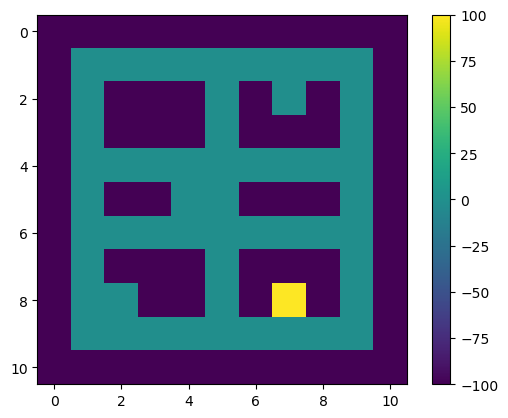

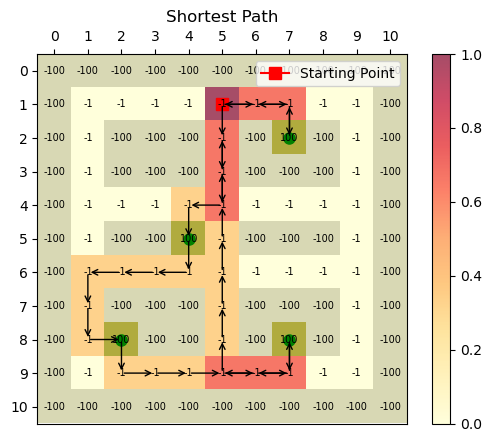

In [55]:
# Define a function to plot the agent's path using a heatmap-like representation
def plot_agent_path(agent_path, reward_locs, start_loc):
    plt.figure()
    colormap = colors.ListedColormap(["gray", "white", "green"])
    im = plt.imshow(REWARD_MAP, cmap=colormap)
    
    ax = plt.gca()

    # Create a heatmap to represent the path
    path_array = np.array(agent_path)
    heatmap = np.zeros_like(REWARD_MAP, dtype=float)
    
    for i in range(len(path_array)):
        row, col = path_array[i]
        heatmap[row, col] += 1

    # Normalize the heatmap values for visualization
    heatmap = heatmap / np.max(heatmap)
    
    heatmap_colors = plt.cm.YlOrRd  # Choose a colormap
    heatmap_image = plt.imshow(heatmap, cmap=heatmap_colors, alpha=0.7)
    
    # Plot arrows indicating direction
    for i in range(len(path_array) - 2):
        curr_row, curr_col = path_array[i]
        next_row, next_col = path_array[i + 1]
        after_next_row, after_next_col = path_array[i + 2]
        
        if (curr_row, curr_col) == (next_row, next_col) or (next_row, next_col) == (after_next_row, after_next_col):
            continue  # Skip repeated locations
        
        arrow_props = dict(arrowstyle='->', linewidth=1, color='black')
        ax.annotate('', xy=(next_col, next_row), xytext=(curr_col, curr_row), arrowprops=arrow_props)

    # Mark reward locations
    for reward_loc in reward_locs:
        row, col = reward_loc
        ax.plot(col, row, marker='o', markersize=8, color='green')
    
    # Mark the starting point
    start_row, start_col = start_loc
    ax.plot(start_col, start_row, marker='s', markersize=8, color='red', label='Starting Point')

    ax.set_xticks(np.arange(0, 11, 1))
    ax.set_yticks(np.arange(0, 11, 1))
    ax.set_xticklabels(np.arange(0, 11, 1))
    ax.set_yticklabels(np.arange(0, 11, 1))
    ax.tick_params(top=True, bottom=False, labeltop=True, labelbottom=False)
    
    for i in range(0, 11):
        for j in range(0, 11):
            text = ax.text(j, i, REWARD_MAP[i, j], ha="center", va="center", color="black", fontsize=7)

    ax.grid(which='minor', color='black', linestyle='-', linewidth=2)
    ax.tick_params(which='minor', bottom=False, left=False)

    ax.set_title("Shortest Path")
    plt.legend()
    plt.colorbar(heatmap_image)  # Add a colorbar for the heatmap
    plt.show()

# Plot the agent's path
start_row, start_col = get_starting_location()
agent_path = get_shortest_path(start_row, start_col)
plot_agent_path(agent_path, reward_locs, (start_row, start_col))